# AUTOENCODIX PACKAGE HANDBOOK
This notebook demonstrates the usage of the autoencodix package.
For now it serves as an internal guideline with the goal to:
- test the package from a user perspective
- serve as a first draft of user documentation
- serve a developer guideline 
  - developer guide will be derrived from this notebook

## 00 Generate mock data
We provide a variable for example data that can be imported easily. Later we show how to use your own data and what do keep in mind when doing so.

In [7]:
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK, EXAMPLE_MULTI_SC, EXAMPLE_PROCESSED_DATA
# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
raw_sc = EXAMPLE_MULTI_SC

## 01 General Pipeline Usage

In [8]:
# imports
import autoencodix as acx
from autoencodix.utils.default_config import DefaultConfig

cpu not relevant here
Epoch: 0, Loss: 902.8508224487305
Epoch: 1, Loss: 876.4703140258789
Epoch: 2, Loss: 849.4972991943359
Make plots


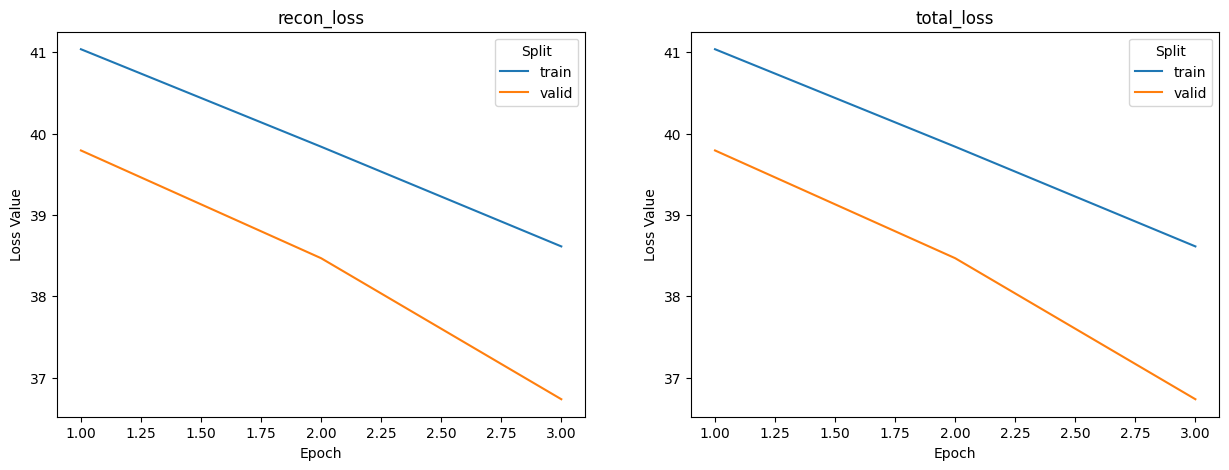

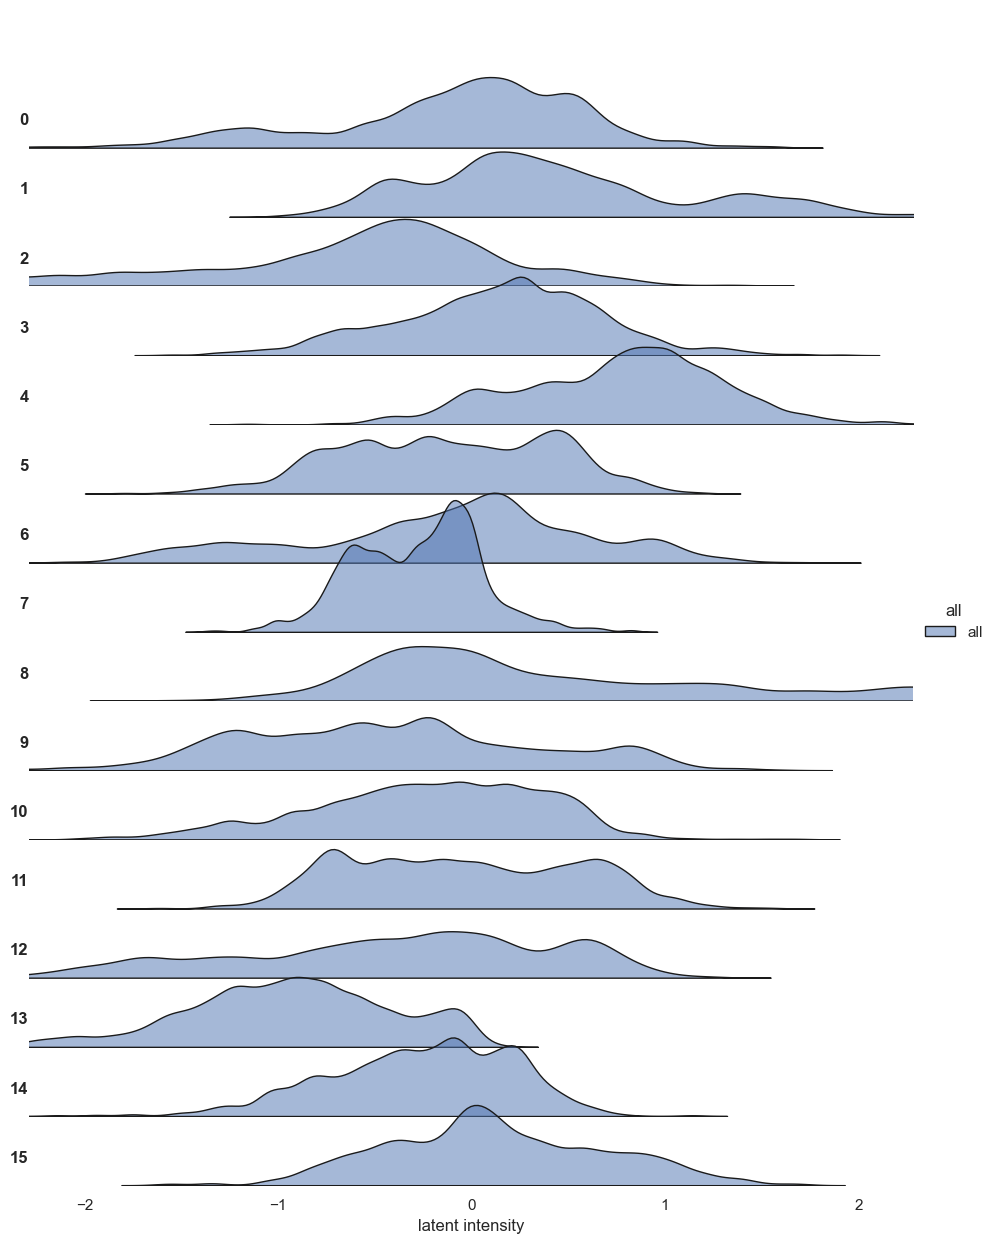

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


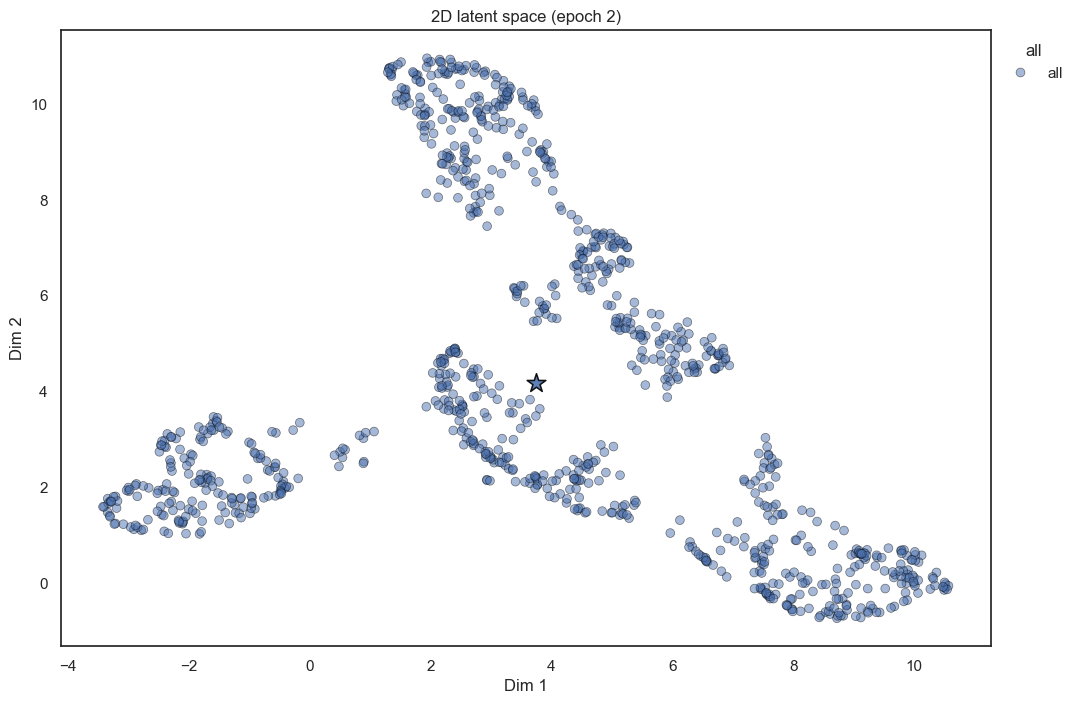

In [9]:
#### --------------------------------------------
# TODO user prepares data or config
### INITIALIZATION ### --------------------------
# Use Vanillix Pipeline interface
# needs to be initialized with data
# data should be a numpy array, pandas dataframe or AnnData object
# possible to pass a custom Config object
van = acx.Vanillix(preprocessed_data=processed_data)
# ------------------------------------------------
### DATA PROCESSING ### --------------------------
# job of old make data
# populates self._datasets attribute with torch dataset
# (important for training with dataloader)
# possible to pass a custom Config object, or keyword arguments
van.preprocess()
# ------------------------------------------------
### MODEL TRAINING ### --------------------------
# job of old make model
# calls self.Trainer class to init and train model
# populates self._model attribute with trained model
# populates self.result attribute with training results (model, losses, etc)
van.fit()
# ------------------------------------------------
### PREDICTION ### -------------------------------
# job of old make predict
# if no data is passed, used the test split from preprocessing
# otherwise, uses the data passed, and preprocesses it
# updates self.result attribute with predictions (latent space, reconstructions, etc)
van.predict()
# ------------------------------------------------
### EVALUATION ### -------------------------------
# job of old make ml_task
# populates self.result attribute with ml task results
van.evaluate()  # not implemented yet
# ------------------------------------------------
### VISUALIZATION ### ---------------------------
# job of old make visualize
# populates self.result attribute with visualizations
van.visualize()
# show visualizations for notebook use
van.show_result()
# --------------------------
# --------------------------


Or run all steps in one command

In [4]:
# run all steps in the pipeline
result_object = van.run()

cpu not relevant here
Epoch: 0, Loss: 902.8508224487305
Epoch: 1, Loss: 876.4703140258789
Epoch: 2, Loss: 849.4972991943359

Invalid parameters: data
Valid parameters are: config


#### Working with Autoencoder TrainingDynamics (i.e. Reconstruction)

In this code, we're retrieving and analyzing reconstructions from our trained autoencoder model. Reconstructions are the output of the autoencoder when it attempts to recreate the original input data after passing it through the bottleneck (latent space).

##### The `.get()` Method Explained

The `reconstructions.get()` method provides flexible access to reconstruction data stored during training. It can retrieve data for specific epochs, specific splits, or any combination of these parameters.


##### Parameters:

- **`epoch`** (Optional[int]): 
  - Positive integer (e.g., `2`): Get reconstructions from that specific epoch
  - Negative integer (e.g., `-1`): Get the latest epoch (-1), second-to-last (-2), etc.
  - `None`: Return data for all epochs

- **`split`** (Optional[str]):
  - Valid values: "train", "valid", "test"
  - `None`: Return data for all splits

##### Return Value Behavior:

The method returns different types depending on the parameters:

1. **Both `epoch` and `split` specified**:
   - Returns a NumPy array for that specific epoch and split
   - Example: `get(epoch=2, split="train")` → `array([...])` 

2. **Only `epoch` specified**:
   - Returns a dictionary of all splits for that epoch
   - Example: `get(epoch=2)` → `{"train": array([...]), "valid": array([...]), ...}`

3. **Only `split` specified**:
   - Returns a NumPy array containing data for that split across all epochs
   - Example: `get(split="train")` → `array([[...], [...], ...])` (first dimension represents epochs)

4. **Neither specified**:
   - Returns the complete nested dictionary structure
   - Example: `get()` → `{0: {"train": array([...])}, 1: {...}, ...}`

##### Special Handling:

- If an invalid split is provided, a `KeyError` is raised
- Negative epoch indices work like Python list indexing (-1 is the last epoch)
- If an epoch doesn't exist, an empty array or dictionary is returned

##### Code Example:

In [5]:
recons = result_object.reconstructions.get(split="train", epoch=2)
recons_val = result_object.reconstructions.get(split="valid", epoch=2)
recons_test = result_object.reconstructions.get(split="test", epoch=-1)

print(f"Training reconstruction shape: {recons.shape} (samples x features)")
print(f"Validation reconstruction shape: {recons_val.shape} (samples x features)")
print(f"Test reconstruction shape: {recons_test.shape} (samples x features)")
print(f"Total reconstructed samples: {recons.shape[0] + recons_val.shape[0] + recons_test.shape[0]}")

Training reconstruction shape: (699, 30) (samples x features)
Validation reconstruction shape: (100, 30) (samples x features)
Test reconstruction shape: (201, 30) (samples x features)
Total reconstructed samples: 1000


In [6]:
latents = result_object.latentspaces.get(split="train", epoch=2)
latents_val = result_object.latentspaces.get(split="valid", epoch=2)
latents_test = result_object.latentspaces.get(split="test", epoch=-1)

print(f"Training latent representations: {latents.shape} (n_samples={latents.shape[0]}, latent_dim={latents.shape[1]})")
print(f"Validation latent representations: {latents_val.shape} (n_samples={latents_val.shape[0]}, latent_dim={latents_val.shape[1]})")
print(f"Test latent representations: {latents_test.shape} (n_samples={latents_test.shape[0]}, latent_dim={latents_test.shape[1]})")
print(f"Total encoded samples: {latents.shape[0] + latents_val.shape[0] + latents_test.shape[0]}")
print(f"Latent space dimensionality: {latents.shape[1]}")


Training latent representations: (699, 16) (n_samples=699, latent_dim=16)
Validation latent representations: (100, 16) (n_samples=100, latent_dim=16)
Test latent representations: (201, 16) (n_samples=201, latent_dim=16)
Total encoded samples: 1000
Latent space dimensionality: 16


#### Using a custom train, test, valid split
When you pass the data to the pipeline, autoencodix, internally splits the data for you based on the train,test, valid ratios provided in the config (defaults are 70%/10%/20% train/valid/test).
You can either pass custom ratios (see next section) or provide the indices directly as shown below

In [10]:
import numpy as np
from autoencodix.utils.default_config import DataCase
sample_data = np.random.rand(100, 10)
custom_train_indices = np.arange(75)  # we won't allow overlap between splits
custom_valid_indices = np.arange(75, 80)
custom_test_indices = np.arange(80, 100)

# the custom split needs to be a dictionary with keys "train", "valid", and "test" and indices of the samples to be included in each split as numpy arrays
custom_split = {
    "train": custom_train_indices,
    "valid": custom_valid_indices,
    "test": custom_test_indices,
}
config = DefaultConfig(data_case=DataCase.MULTI_BULK)
van = acx.Vanillix(raw_user_data=raw_bulk, custom_splits=custom_split, config=config)
van.preprocess()
van.fit(epochs=3)

Applying VAR filtering
Shape changed from (350, 100) to (350, 100)
Shape changed from (350, 100) to (350, 100)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (350, 80) to (350, 80)
Shape changed from (350, 80) to (350, 80)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (50, 100) to (50, 100)
Shape changed from (50, 100) to (50, 100)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (50, 80) to (50, 80)
Shape changed from (50, 80) to (50, 80)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (100, 100) to (100, 100)
Shape changed from (100, 100) to (100, 100)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (100, 80) to (100, 80)
Shape changed from (100, 80) to (100, 80)
Applying STANDARD scaling
{'train': {'data': multi_bulk:
  transcriptomics: 350 samples × 100 features
  proteomics: 350 samples × 80 features
annotation:
  transcriptomics: 350 samples × 3 features
  proteomics: 350 samples

It is possible to pass empty splits, but depending on how you'll use the autoencodix pipeline, this will throw an error at some point. So it is possible to call `fit` with only training data, but if you want to call `predict` and don't provide new data, this won't work without a data in the test split

#### Using predict with new data
The standard case is to train the model with the train data and then predict with the test split.
However, it is possible to pass new data to the predict method to perform inference on this data with the already trained model

#### Examining the result of the pipeline
Each step in the pipeline writes its results in the result object of the Vanillix instance.
In this section we explore how to access and make sense of the results.

In [9]:
result = van.result
print(result)

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: _FabricModule
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=<autoencodix.data._numeric_dataset.NumericDataset object at 0x33b939480>, valid=<autoencodix.data._numeric_dataset.NumericDataset object at 0x33f61e260>, test=<autoencodix.data._numeric_dataset.NumericDataset object at 0x33f61f430>)


##### TrainingDynamics object in result
The training dynamics object has the followinf form:
<epoch><split><data>
So if you want to access the train loss for the 5th epoch, you would:
`result.lossss.get(epoch=5, split="train")`

In [ ]:
loss_train_ep2 = result.losses.get(epoch=2, split="train")
print(loss_train_ep2)
valid_loss = result.losses.get(split="valid")
print(valid_loss)
print(result.losses.get())

0.7134380141894022
[0.27492604 0.24243712 0.23720634]
{0: {'train': array(0.78907921), 'valid': array(0.27492604)}, 1: {'train': array(0.71213861), 'valid': array(0.24243712)}, 2: {'train': array(0.71343801), 'valid': array(0.23720634)}}


In [1]:
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK, EXAMPLE_MULTI_SC, EXAMPLE_PROCESSED_DATA
# EXAMPLE_DATA hold PyTorch Datasets (child with extra info) with metdata for train, test and valid splits
processed_data = EXAMPLE_PROCESSED_DATA
raw_bulk = EXAMPLE_MULTI_BULK
raw_sc = EXAMPLE_MULTI_SC

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: this schema works for every TrainingDynamics instance in the results object.

## 02 Pipeline usage with custom parameters
Here we show how to customize the above shown pipeline with a user config or with keyword arguments.
In future iterations we want to allow to read a config from a file, this will be also demonstrated here.

In [11]:
# Use Vanillix Pipeline interface
# needs to be initialized with data
# data should be a numpy array, pandas dataframe or AnnData object
# possible to pass a custom Config object
van = acx.Vanillix(preprocessed_data=processed_data)
# job of old make data
# populates self._features attrbute with torch tensor
# populates self._datasets attribute with torch dataset
# (important for training with dataloader)
# possible to pass a custom Config object, or keyword arguments
van.preprocess()
# job of old make model
# calls self.Trainer class to init and train model
# populates self._model attribute with trained model
# populates self.result attribute with training results (losses, etc)
# van.fit()
""" 
Each step can be run separately, with custom parameters, these parameters
can be passed as keyword arguments, or as a Config object
"""
van.fit(learning_rate=0.01, batch_size=32, epochs=5)  # or like this:
my_config = DefaultConfig(learning_rate=130.0, batch_size=32, epochs=5)
van.fit(config=my_config)  # config has to be an keyword argument

cpu not relevant here
Epoch: 0, Loss: 902.8508224487305
Epoch: 1, Loss: 876.4703140258789
Epoch: 2, Loss: 849.4972991943359
cpu not relevant here
Epoch: 0, Loss: 902.8508224487305
Epoch: 1, Loss: 876.4703140258789
Epoch: 2, Loss: 849.4972991943359


#### 02.1  How to relevant keyword arguments for pipeline methods
It can be hard to know what keyword arguments are valid for each step,
so we show:
- how to get a list of allowed keyword arguments
- what happens if you pass non-allowed keyword arguments

In [14]:

import pprint
# for each config method, we can call a valid_params method
van = acx.Vanillix(preprocessed_data=processed_data)
fit_params = (
    van.fit.valid_params
)  # returns a set of keyword arguments that are actually used in the fit method


pprint.pprint(fit_params)

{'batch_size',
 'checkpoint_interval',
 'config',
 'device',
 'epochs',
 'global_seed',
 'gpu_strategy',
 'learning_rate',
 'n_gpus',
 'n_workers',
 'reconstruction_loss',
 'reproducible',
 'weight_decay'}


To get even more verbose info about the keyword args, you can run the following code.

In [15]:
# when you want to have more info about the params, you can get type hints from the config object
my_config = DefaultConfig()
conig_values = my_config.get_params()
my_config.print_schema(filter_params=fit_params)

Valid Keyword Arguments:
--------------------------------------------------

learning_rate:
  Type: <class 'float'>
  Default: 0.001
  Description: Learning rate for optimization

batch_size:
  Type: <class 'int'>
  Default: 32
  Description: Number of samples per batch

epochs:
  Type: <class 'int'>
  Default: 3
  Description: Number of training epochs

weight_decay:
  Type: <class 'float'>
  Default: 0.01
  Description: L2 regularization factor

reconstruction_loss:
  Type: typing.Literal['mse', 'bce']
  Default: mse
  Description: Type of reconstruction loss

device:
  Type: typing.Literal['cpu', 'cuda', 'gpu', 'tpu', 'mps', 'auto']
  Default: auto
  Description: Device to use

n_gpus:
  Type: <class 'int'>
  Default: 1
  Description: Number of GPUs to use

n_workers:
  Type: <class 'int'>
  Default: 2
  Description: Number of data loading workers

checkpoint_interval:
  Type: <class 'int'>
  Default: 1
  Description: Interval for saving checkpoints

gpu_strategy:
  Type: typing.Lit

If you pass not supported parameters you get a warning

In [16]:
# if you use an unsupported keyword argument, you will get a warning
# as you see the default value from the DefaultConfig is not overwritten and the training will take 100 epochs (not 10)
van.preprocess()
van.fit(epochds=10)


Invalid parameters: epochds
Valid parameters are: batch_size, checkpoint_interval, config, device, epochs, global_seed, gpu_strategy, learning_rate, n_gpus, n_workers, reconstruction_loss, reproducible, weight_decay
cpu not relevant here
Epoch: 0, Loss: 902.8508224487305
Epoch: 1, Loss: 876.4703140258789
Epoch: 2, Loss: 849.4972991943359


#### 02.2 How to get information about the default config parameters

In [17]:
# if you want to see what config parameters are used in the default config you can do it like:
default_config = DefaultConfig()
default_config.print_schema()


DefaultConfig Configuration Parameters:
--------------------------------------------------

data_config:
  Type: <class 'autoencodix.utils.default_config.DataConfig'>
  Default: data_info={} require_common_cells=False annotation_columns=None
  Description: No description available

paired_translation:
  Type: typing.Optional[bool]
  Default: PydanticUndefined
  Description: Indicator if the samples for the xmodalix are paired, based on some sample id

data_case:
  Type: typing.Optional[autoencodix.utils.default_config.DataCase]
  Default: PydanticUndefined
  Description: Data case for the model, will be determined automatically

latent_dim:
  Type: <class 'int'>
  Default: 16
  Description: Dimension of the latent space

n_layers:
  Type: <class 'int'>
  Default: 3
  Description: Number of layers in encoder/decoder, without latent layer. If 0, is only the latent layer.

enc_factor:
  Type: <class 'int'>
  Default: 4
  Description: Scaling factor for encoder dimensions

input_dim:
  Ty

### 02.3 Documentation Config class
You can update the config with your own values by:
- passing arguments as:
    - dict
    - single arguments
- passing a file (TODO)

In [18]:
from autoencodix.utils.default_config import DefaultConfig

# METHOD 1: override the default config with a dictionary
my_args = {"learning_rate": 0.0234, "batch_size": 13, "epochs": 12}
my_config = DefaultConfig(**my_args)
# METHOD 2: override signle parameters
my_new_conig = DefaultConfig(latent_dim=23, n_gpus=13)

# METHOD 3: from a file: TODO

## 03 Use the Varix model
Now we show how easy it is to use a variational autoencoder instead of a vanilla version.

In [3]:
from autoencodix.utils.default_config import DefaultConfig
import autoencodix as acx

my_config = DefaultConfig(learning_rate=0.001, epochs=3, checkpoint_interval=1)
varix = acx.Varix(preprocessed_data=processed_data, config=my_config)
result = varix.run()

cpu not relevant here
[30, 16, 16, 16, 16]
Epoch: 0, Loss: 898.5270881652832
Epoch: 1, Loss: 887.3589286804199
Epoch: 2, Loss: 878.5628433227539

Invalid parameters: data
Valid parameters are: config


#### Examine Variational result
Here, we have more info in our results object than in the Vanillix case. We have the learned paramters mu and logvar of the normal distirbution, in addition to the losses and reconstructions. We provide also the sampled latentspaces at each epoch and split.

You can resample new latenspaces (shown in next section)

In [4]:
# we did not train for the test split, so we don't need to pass an epoch
# technically the epoch is -1
mu_test_ep_last = result.latentspaces.get(split="test")
print(mu_test_ep_last.shape)

(1, 201, 16)


#### Different loss types
For our variation autoencoder, the total loss consists of a reconstruction loss and a distribution loss i.e. kl-divergence. To investigate these losses, the result_obj has the attribute `sub_losses`. This is a `LossRegistry` withe the name of the loss as key and the value is of class `TrainingDynamics` and can be accessed as shown for the Vanillix part

In [5]:
sub_losses = result.sub_losses
print(f"keys: {sub_losses.keys()}")
recon_dyn = sub_losses.get(key="recon_loss")
print(recon_dyn.get(split="train"))

keys: dict_keys(['recon_loss', 'var_loss'])
[40.83634706 40.3286138  39.9277831 ]


#### Sample new latentspaces
You might want to use the trained model and the fitted parameters mu, and logvar to sample latentspaces. Therefore, the Varix pipeline has the additional method `sample_latent_space`

In [6]:
sampled = varix.sample_latent_space()

print(sampled[:5])

tensor([[-0.4633, -0.1883,  0.0721, -0.6220,  0.9275, -0.2603,  0.1878,  0.8052,
          0.4403,  2.3060, -1.4210, -1.3647, -0.8144,  0.6377, -1.4955, -0.2871],
        [-0.9388, -1.4924, -1.8572, -1.3836, -0.4924,  0.2619, -1.1339,  1.0985,
         -1.5843,  1.2825,  0.9220,  1.1582, -0.3446,  1.3647, -1.3268,  0.3792],
        [ 0.4343, -0.4509,  0.0618,  0.0242, -1.6079,  0.5152, -1.1729,  0.0553,
          0.0149, -0.9234,  0.0594, -0.0980,  1.3418, -1.1129, -0.9010,  0.8607],
        [ 0.0480,  1.6085,  1.4646,  0.8741,  1.7955, -0.1133, -1.1896,  0.7912,
          0.9866,  0.8465, -1.3911,  1.9091,  0.2493, -0.5283,  2.0410, -1.7638],
        [ 0.1578,  0.3169,  0.0088,  0.6864, -0.3666, -0.9001,  0.1643, -0.1540,
         -1.6208, -0.1900, -1.3184, -0.5792,  1.0865,  0.5480, -0.0598,  0.7108]],
       device='mps:0')


In [7]:
# you can also select a specific epoch and split to sample from (default is last epoch and test split)
sampled = varix.sample_latent_space(epoch=2, split="valid")
print(sampled[:5])

tensor([[ 0.3167,  1.0705,  0.9425, -1.2487,  1.0592,  0.5767,  1.4834,  0.3958,
         -0.2660,  1.0815,  0.8067,  2.1069,  1.7246,  0.5642,  2.2832,  0.8107],
        [-0.4772,  0.8572, -0.8692, -0.2016,  1.8884, -0.4607, -0.0728, -0.7979,
         -0.2394,  0.9491,  0.0426,  4.6014,  3.6367,  2.9212,  0.1386,  1.5645],
        [ 1.1572,  1.8602,  0.4208, -0.1139, -2.2424,  2.3398,  0.3758,  2.5682,
         -0.5520,  0.0490,  0.6585,  0.4207,  0.6792, -0.2264, -0.6643, -0.3891],
        [-1.1170,  0.8188, -0.5963, -0.9456,  0.9971,  0.3094,  1.0553,  2.3242,
          0.8726,  1.0506,  0.5314, -0.4483, -0.8818,  0.6893,  0.8181,  1.0236],
        [-0.4543, -0.9201, -0.5272, -0.3452,  0.7443, -0.1536, -3.9498,  1.0767,
          0.4042,  1.1613, -1.1359,  0.8239, -0.3311,  0.2191, -1.3863, -0.7465]],
       device='mps:0')


In [8]:
# or sample multiple times
for _ in range(5):
    sampled = varix.sample_latent_space()
    print(sampled[:3, :3])

tensor([[-2.5886,  0.5678,  1.0223],
        [ 1.0024, -0.1222, -0.2208],
        [ 0.2891, -0.8719,  0.0733]], device='mps:0')
tensor([[ 0.4863, -0.0268,  0.7755],
        [ 0.3265, -0.1244, -1.2262],
        [-1.2366,  0.3115, -1.2244]], device='mps:0')
tensor([[ 2.6476, -1.5012,  0.7672],
        [ 0.2688, -0.7790, -1.2514],
        [ 0.5527,  0.4400, -1.1674]], device='mps:0')
tensor([[ 2.2283,  1.4636, -0.7216],
        [ 2.6344,  0.9172,  1.9615],
        [ 1.1227,  1.6702,  0.2593]], device='mps:0')
tensor([[ 0.3254, -1.1050,  0.5470],
        [-0.2322, -0.3638,  1.0204],
        [ 0.6681, -0.3327, -1.0409]], device='mps:0')


## 04 How to work with custom omics data
In the above steps we showed how to use `Autoencodix` with mock data. Nowe we demonstrate how to use real-world data. We'll cover:
1. combining multi-omics data from bulk sequencing (e.g. mRNA and methylation)
2. combining multi-omics data from single cell sequencing
3. "Translating" between multi-omics data e.g. scRNA <-> scATAC, or bulkmRNA <-> bulkmiRNA
4. Working with image data
5. "translating" between data-modalities
  - one bulk-omics modality to another
  - omics to image an vice versa

### 04.1 Combining mulit-omics data from bulk-sequencing
First we need to prepare our config object. We can (a) directly provide an object in python, or (b) provide an YAML file. We show both

#### YAML config
Assume we have the file in `./config.yaml`.
We can keep the yaml file structure to define our input data like:
```yaml
data_config: # has to be named data_config
  data_info: # has to be named data_infor
   RNA: # name can be chosen by user
     file_path: "data/raw/data_mrna_seq_v2_rsem_formatted.parquet"
     is_single_cell: false # default false, added for verbosity
   METHYLATION: # can be chosen by user
     file_path: "data/raw/data_methylation_per_gene_formatted.parquet"
     is_single_cell: false # default false, added for verbosity
   CLINICAL: # can be chosen by user
     file_path: "data/raw/data_clinical_formatted.parquet"
     data_type: "ANNOTATION" # default NUMERIC (as for RNA and METHYLATION)
```
ATTENTION:
If you use `.txt` or `.csv` files, it is best practice to add the `sep` parameter. If none is given, the reader will try to auto-detect the separator, which is error prone.
This would loke like:
```YAML
    RNA:
      ...
      sep: "\t" # for tab, ";" or "," would be also possible (as in pandas)

```
#### IMPORTANT
For all your bulk data files, we expect the first column to be some kind of unique sample id. Please prepare the data accordingly.

In [14]:
import yaml
from pathlib import Path
from autoencodix.utils.default_config import DefaultConfig
import os

print(os.getcwd())
# this fills the data_config attribute of the DefaultConfig object
# we can also change the default values in the config.yaml file
# or via the DefaultConfig object
data_info = DefaultConfig.model_validate(
    yaml.safe_load(Path("configs/multi_bulk.yaml").read_text())
)

/Users/maximilianjoas/development/autoencodix_package


In [15]:
# with custom values
custom_config = DefaultConfig.model_validate(
    {
        **yaml.safe_load(Path("configs/multi_bulk.yaml").read_text()),
        "learning_rate": 0.77,
    }
)

In [16]:
print(data_info.data_config)
print(data_info.learning_rate)
print(custom_config.learning_rate)

data_info={'RNA': DataInfo(file_path='data/raw/mini/bulk/rna_sample_data.csv', data_type='NUMERIC', scaling='STANDARD', filtering='VAR', k_filter=100, sep=',', extra_anno_file=None, is_single_cell=False, min_cells=0.05, min_genes=0.01, selected_layers=['X'], is_X=False, normalize_counts=True, log_transform=True, img_root=None, img_width_resize=None, img_height_resize=None, translate_direction=None), 'METHYLATION': DataInfo(file_path='data/raw/mini/bulk/meth_sample_data.tsv', data_type='NUMERIC', scaling='STANDARD', filtering='VAR', k_filter=None, sep='\t', extra_anno_file=None, is_single_cell=False, min_cells=0.05, min_genes=0.01, selected_layers=['X'], is_X=False, normalize_counts=True, log_transform=True, img_root=None, img_width_resize=None, img_height_resize=None, translate_direction=None), 'CLINICAL': DataInfo(file_path='data/raw/mini/bulk/clinical_sample_data.parquet', data_type='ANNOTATION', scaling='STANDARD', filtering='VAR', k_filter=None, sep=None, extra_anno_file=None, is_s

#### Create DataConfig in Python
We will only use one way of config creation for the next examples.

In [17]:
from autoencodix.utils.default_config import DataConfig, DataInfo

root_dir = os.path.join("data/raw")
meth_file = "data_methylation_per_gene_formatted.parquet"
mrna_file = "data_mrna_seq_v2_rsem_formatted.parquet"
clin_file = "data_clinical_formatted.parquet"

bulk_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "RNA": DataInfo(file_path=os.path.join(root_dir, mrna_file)),
            "METHYLATION": DataInfo(file_path=os.path.join(root_dir, meth_file)),
            "CLINICAL": DataInfo(
                file_path=os.path.join(root_dir, clin_file), data_type="ANNOTATION"
            ),
        }
    )
)

#### Building the input data
Practically we would be done with the above step. We pass the config to the pipeline as shown multiple times before. For cleared documentation (esepcially for Devs) we show what happens inside the pipeline

In [ ]:
from autoencodix.utils._bulkreader import BulkDataReader

bulkreader = BulkDataReader(config=bulk_config)
bulk_dfs, anno_dfs = bulkreader.read_data()
print(type(bulk_dfs))

<class 'dict'>


In [ ]:
print(bulk_dfs.keys())
print(anno_dfs.keys())

dict_keys(['RNA', 'METHYLATION'])
dict_keys(['paired'])


##### How the data is handled internally.
The BasePreprocessor class has a `datapackage` attribute. This is a instance of a class that holds, this class holds four attributes:
- bulk_dfs_dict (dict with pdDataframes),holding bulk data
- anndata: AnnData for singcle cell
- annotation: pd.Dataframe (for metadata duplciate with anndata.obs in sc case)
- ImgData with list of images and image metadata

### 04.2 Working with single cell data from different sequencing processes
First we define our config again, then we use the reader object to build the AnnData (this will look more familar for single cell practioners)

We can provide a config yaml like:
```YAML
# config.yaml
data_config:
 data_info:
   RNA:
     file_path: "data/raw/Sc-1.h5ad" # we request h5ad files
     is_single_cell: true
     min_cells: 0.01
     min_genes: 0.01
     is_X: true
   METH:
     file_path: "data/raw/Sc-2.h5ad"
     is_single_cell: true
     min_cells: 0.01
```

In [22]:
from autoencodix.utils import DefaultConfig
import yaml
from pathlib import Path

scconfig = DefaultConfig.model_validate(
    yaml.safe_load(Path("configs/largesc.yaml").read_text())
)

In [23]:
from autoencodix.utils._screader import SingleCellDataReader

screader = SingleCellDataReader()
mudata = screader.read_data(config=scconfig)

Number of common cells: 4554


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:449: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


In [24]:
print(mudata)

{'multi_sc': View of MuData object with n_obs × n_vars = 4554 × 18018
  2 modalities
    RNA:	4554 x 9009
      obs:	'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
      var:	'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
      uns:	'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
      obsm:	'X_joint_wnn_umap', 'X_umap'
      layers:	'log2_X', 'log_X'


### 04.3 Translating between omics data
We only allow bulk to bulk and single-cell to single cell. The config is almost identical to the case before, we only add the direction of the translation like:
```YAML
data_config:
 data_info:
   RNA:
     file_path: "data/raw/Sc-1.h5ad"
     is_single_cell: true
     min_cells: 0.01
     min_genes: 0.01
     is_X: true
     translate_direction: "FROM"
   METH:
     file_path: "data/raw/Sc-2.h5ad"
     is_single_cell: true
     min_cells: 0.01
     translate_direction: "TO"

```

For the bulk case we can keep annotation data without including it in the translation like:
```YAML
# config.yaml
data_config:
  data_info:
   RNA:
     file_path: "data/raw/data_mrna_seq_v2_rsem_formatted.parquet"
     is_single_cell: false
     translate_direction: "FROM"
   METHYLATION:
     file_path: "data/raw/data_methylation_per_gene_formatted.parquet"
     is_single_cell: false
     translate_direction: "TO"
   CLINICAL:
     file_path: "data/raw/data_clinical_formatted.parquet"
     data_type: "ANNOTATION"
     # default translate_direction is  NONE, so we don't need to specify it here
```

### 04.4 Working with images
When working with images, we need have two cases:
- pure image, without translating
- translating between omics and images

In the first case we need to provide the folder path of the images. In the second case we need to provide the folder path of the images and an annotation file that maps the metadata for the images to the image filenames. In this file we also need to map the sample_ids of the other data modality to the image filename and metadata. Later we will add support for an unpaired case, where we only provide image metadata without mapping to the other data modality.
The file should look like this:
**important**: this file needs to contain the columns `sample_ids` and `img_paths`
```text
sample_ids	img_paths	METADATA1	METADATA2
TCGA-05-4244-01	0_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4249-01	1_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4250-01	2_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4382-01	3_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4384-01	4_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4389-01	5_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4390-01	6_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4395-01	7_label_1.png	Non-Small Cell Lung Cancer	LUAD
TCGA-05-4396-01	8_label_1.png	Non-Small Cell Lung Cancer	LUAD
```

#### Image only case

In [25]:
from autoencodix.utils.default_config import DataConfig, DataInfo

img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(file_path="data/raw/images/tcga_fake", data_type="IMG"),
            "ANNO": DataInfo(
                file_path="data/raw/tcga_mappings.txt", data_type="ANNOTATION"
            ),
        }
    )
)

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/default_config.py:331: UserWarning: Could not determine data_case: No numeric datasets found in data_info
  warnings.warn(f"Could not determine data_case: {str(e)}")


#### Images and omics data
If you want to translate between image and another data modality you need to provide the same files as above. For the Annotation files you have two possibilities: (a) you provide one annotation file (as shown above), in this file you match the metadata of the two data modalites, by an shared sample_id / mapping of sample_id and image_path and other metadata. (b) you can have supply an extra annotation file for the images with the attribute `img_anno_file`. If None is given, we will use the shared file. This is only allowed for unpaired translation.
So for the unpaired translation the `DataConfig` should look like:

In [26]:
from autoencodix.utils.default_config import DataConfig, DataInfo, DefaultConfig

img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path="data/raw/images/tcga_fake",
                data_type="IMG",
                translate_direction="to",
            ),
            "RNA": DataInfo(
                file_path="data/raw/data_mrna_seq_v2_rsem_formatted.parquet",
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "ANNO": DataInfo(
                file_path="data/raw/tcga_mappings.txt",
                data_type="ANNOTATION",
            ),
        }
    )
)

In [27]:
from autoencodix.utils._imgreader import ImageDataReader

imgreader = ImageDataReader()
imgdata = imgreader.read_data(config=img_config)

reading annotation file: data/raw/tcga_mappings.txt


/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:192: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


In [33]:
print(imgdata.keys())
print(f"Number of images: {len(imgdata['IMG'])}")

dict_keys(['IMG'])
Number of images: 3204


#### Unpaired case
This case is not implemented in the old version of `autoencodix` and will be added after the other translating features, we still show how the config can look like:
```python
from autoencodix.utils.default_config import DataConfig, DataInfo
img_config = DefaultConfig(
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path="data/raw/images/tcga_fake.txt",
                data_type="IMG",
                translate_direction="to"
                extra_anno_file="path/to/file"
            ),
            "RNA": DataInfo(
                file_path="data/raw/data_mrna_seq_v2_rsem_formatted.parquet",
                data_type="NUMERIC",
                translate_direction="from"
            ),
            "ANNO": DataInfo(
                file_path="data_clinical_formatted.parquet",
                data_type="ANNOTATION",
            ),
        }
    )
)


#### Internal handling of image data
Image and bulk case (paired)


## 05 How to add a new architecture
### High level workflow
To add a new autoencoder architecture, you need to at least code two things:
- the model architecture itself in  `src/autoencodix/modeling/` - anlogous to `_varix_architecture.py`
- the pipeline itself in `src/autoencodix/` - analgous to `varix.py`
Depending on the complexity and data requirements you might also want to provide the following:
- a new custom dataset class in `src/autoencodix/data` - analogous to `numeric_dataset.py`
- a new custom preprocessor in `src/autoencodix/data` - as in `preprocessor.py`
- a new custom trainer in `src/autoencodix/trainers` - as in `_general_trainer.py`
  - including a custom predict method of your trainer
- a custom loss for your model
- a custom visualizer (no example implemented yet)
- a custom evaluator for downstream tasks (no example implemented yet)
- a custom tuner (not sure if this will be part of the package)
### High level structure
- Each autoencodix model in our family is based on our base classes in `src/autoencodix/base`. Here we have (often abstract) classes that define the general structure of each step (preprocess, fit, predict, evaluate, visualize) in our pipeline, as well as additional classes e.g. losses.
- In these base classes we've implemented shared functionalities, like calling the corresponding trainer, or preprocessor.
- The base classes also guide you to the structure of your new class. The methods of the base classes should not be changed. Rather overwrite the method in the implementation of your child class in case you need to make changes.

### Must-do files details
We'll illustrate this by an example. We want to add the new architecture with the name MySpecial to our package. First we add the actual architecture:
- create the file `src/autoencodix/modeling/_myspecialix_architecture.py` (note files that should not be imported at end-user lever have a leading underscore).
- create the file `tests/test_modelling/test_myspecialix_architecture`
- we write the class itself that might look like:
```python
from autoencodix.base._base_autoencoder import BaseAutoencoder
# your imports
# TODO


# needs to inherit from BaseAutoencoder
class MySpecialArchitecture(BaseAutoencoder):
    """
    MySpecial implementation accroding to (cite paper, yourself, etc)

    Attributes
    ----------
    self.input_dim : int
        number of input features
    self.config: DefaultConfig
        Configuration object containing model architecture parameters
    self._encoder: nn.Module
        Encoder network of the autoencoder
    self._decoder: nn.Module
        Decoder network of the autoencoder

    Methods
    -------
    my_super_special_method():
        does cool stuff
    _build_network()
        Construct the encoder and decoder networks via the LayerFactory
    encode(x: torch.Tensor) -> torch.Tensor
        Encode the input tensor x
    decode(x: torch.Tensor) -> torch.Tensor
        Decode the latent tensor x
    forward(x: torch.Tensor) -> ModelOutput
        Forward pass of the model, fills in the reconstruction and latentspace attributes of ModelOutput class.

    """

    def __init__(
        self, config: Optional[Union[None, DefaultConfig]], input_dim: int
    ) -> None:
        if config is None:
            config = DefaultConfig()
        self._config = config
        super().__init__(config, input_dim)
        self.input_dim = input_dim # we always base the input dimension (usually number of features in your dataset)

        # populate self.encoder and self.decoder
        self._build_network()

    def _build_network(self) -> None:
        """
        Construct the encoder and decoder networks.
        See your _layer_factory.py file that could help you here.
        Also check other implementation to see how to use _layer_factory.py
        """
        self._encoder = TODO
        self._decoder = TODO


    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encode the input tensor x

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        torch.Tensor
            Encoded tensor

        """
        encoded = self._encoder(x)
        return encoded


    def decode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Decode the latent tensor x

        Parameters
        ----------
        x : torch.Tensor
            Latent tensor

        Returns
        -------
        torch.Tensor
            Decoded tensor

        """
        return self._decoder(x)

    def forward(self, x: torch.Tensor) -> ModelOutput:
        """
        Forward pass of the model, fill

        Parameters
        ----------
        x : torch.Tensor
            Input tensor

        Returns
        -------
        ModelOutput
            ModelOutput object containing the reconstructed tensor and latent tensor

        """
        latent = self.encode(x)
        x_hat = self.decode(z)
        # fill model output arcodding to your needs (we need reconstruction and a latentspace, see ModelOuput class for required output)
        return ModelOutput(
            reconstruction=x_hat,
            latentspace=latent
            latent_mean=None,
            latent_logvar=None,
            additional_info=None,
        )

```
- adjust the `__init__.py` in `src/autoencodix/modelling` to import `MySpecialArchitecture
- next we write tests for the newly created file in the test file
- lastly, we need to create the pipeline file:
  - create `src/autoencodix/myspecialix.py`
  - create `tests/test_myspecialix.py`
- the `myspecialix.py` might look like this
```python
# your imports
# TODO

class MySpecialix(BasePipeline): # must inhertit from BasePipeline
    """
    MySpecialix specific version of the BasePipeline class.
    Inherits preprocess, fit, predict, evaluate, and visualize methods from BasePipeline.

    Attributes
    ----------
    data : Union[np.ndarray, AnnData, pd.DataFrame]
        Input data from the user
    config : Optional[Union[None, DefaultConfig]]
        Configuration object containing customizations for the pipeline
    _preprocessor : Preprocessor
        Preprocessor object to preprocess the input data (custom for Vanillix)
    _visualizer : Visualizer
        Visualizer object to visualize the model output (custom for Vanillix)
    _trainer : GeneralTrainer
        Trainer object that trains the model (custom for Vanillix)
    _evaluator : Evaluator
        Evaluator object that evaluates the model performance or downstream tasks (custom for Vanillix)
    result : Result
        Result object to store the pipeline results
    _datasets : Optional[DatasetContainer]
        Container for train, validation, and test datasets (preprocessed)
    data_splitter : DataSplitter
        DataSplitter object to split the data into train, validation, and test sets
    """

    def __init__(
        self,
        data: Union[np.ndarray, AnnData, pd.DataFrame],
        # this can be also a custom Type like MySpecialixDataset
        dataset_type: Type[BaseDataset] = NumericDataset,
        # This will be the Type MySpecialixArchitecture that we created before
        model_type: Type[BaseAutoencoder] = MySpecialixArchitecture,
        # This can be a custom Loss class, or an exisiting one see _losses.py
        loss_type: Type[BaseLoss] = VanillixLoss,
        preprocessor: Optional[Preprocessor] = None,
        visualizer: Optional[BaseVisualizer] = None,
        evaluator: Optional[Evaluator] = None,
        result: Optional[Result] = None,
        datasplitter_type: Type[DataSplitter] = DataSplitter,
        custom_splits: Optional[Dict[str, np.ndarray]] = None,
        config: Optional[DefaultConfig] = None,
    ) -> None:
        """Initialize MySpecialix pipeline with customizable components.

        Some components are passed as types rather than instances because they require
        data that is only available after preprocessing.

        Parameters
        ----------
        data : Union[np.ndarray, AnnData, pd.DataFrame]
            Input data to be processed
        trainer_type : Type[BaseTrainer]
            Type of trainer to be instantiated during fit step, default is GeneralTrainer
        dataset_type : Type[BaseDataset]
            Type of dataset to be instantiated post-preprocessing, default is NumericDataset
        loss_type : Type[BaseLoss], which loss to use for Vanillix, default is VanillaAutoencoderLoss
        preprocessor : Optional[Preprocessor]
            For data preprocessing, default creates new Preprocessor
        visualizer : Optional[Visualizer]
            For result visualization, default creates new Visualizer
        evaluator : Optional[Evaluator]
            For model evaluation, default creates new Evaluator
        result : Optional[Result]
            Container for pipeline results, default creates new Result
        datasplitter_type : Type[DataSplitter], optional
            Type of splitter to be instantiated during preprocessing, default is DataSplitter
        custom_splits : Optional[Dict[str, np.ndarray]]
            Custom train/valid/test split indices
        config : Optional[DefaultConfig]
            Configuration for all pipeline components
        """
        super().__init__(
            data=data,
            dataset_type=dataset_type,
            trainer_type=trainer_type,
            model_type=model_type,
            loss_type=loss_type,
            preprocessor=preprocessor or Preprocessor(),
            visualizer=visualizer or Visualizer(),
            evaluator=evaluator or Evaluator(),
            result=result or Result(),
            datasplitter_type=datasplitter_type,
            config=config or DefaultConfig(),
            custom_split=custom_splits,
        )

```
##### More explaination to the passing of Types instead of classes:
Most functionality of the pipeline comes from the BasePipeline. To make the methods custom to our specific architecture that we use in our `MySpecial` pipeline, we need to pass our specializes subclasses. Since we don't have all required parameters for this subclasses when calling the init method of the parent class, we pass only the type of the subclasses. These types need to be childs of the corresponding base class. Inside the BasePipeline we instantiate the specific classes with the required paramters as soon as we have them
### Optional files details
The optional files work from the same principle as the mandatory files, so we can always create a special class based on the baseclass and then we pass the type of our special class to our MySpecialix Pipeline e.g MySpecialTrainer n the init mehtod of MySpecialix (same as we did with MySpecialArchitecture)

# TODOS
- show how to update and work with the config object (later)

### SANDBOX 
testing Varix and losses, especially sub_losses in result_object

### Preprocessing
#### P1 Reading data


In [ ]:
import os

os.chdir("..")
print(os.getcwd())

/Users/maximilianjoas/development/autoencodix_package


In [ ]:
from autoencodix.utils.default_config import DefaultConfig
import yaml
from pathlib import Path
from autoencodix.utils._screader import SingleCellDataReader
from autoencodix.utils._bulkreader import BulkDataReader
from autoencodix.utils._imgreader import ImageDataReader
from autoencodix.data._numeric_dataset import NumericDataset


from autoencodix.base._base_preprocessor import BasePreprocessor


##### config paths

In [ ]:
bulk_path = "configs/largebulk.yaml"
scpath = "configs/largesc.yaml"
tranpath = "configs/sc_img_tran_config.yaml"
unpaired_path = "configs/bulk_img_up.yaml"

In [ ]:
bulk_config = DefaultConfig.model_validate(yaml.safe_load(Path(bulk_path).read_text()))
scconfig = DefaultConfig.model_validate(yaml.safe_load(Path(scpath).read_text()))
tranconfig = DefaultConfig.model_validate(yaml.safe_load(Path(tranpath).read_text()))
unpaired_config = DefaultConfig.model_validate(
    yaml.safe_load(Path(unpaired_path).read_text())
)

In [ ]:
scconfig.data_config.data_info["RNA"].selected_layers

['X', 'log_X', 'log2_X']

### Dataset building

In [ ]:
from typing import Any, Dict, List, Union
import torch
import numpy as np
import pandas as pd
from scipy.sparse import issparse
import mudata as md
from autoencodix.data._numeric_dataset import NumericDataset
from autoencodix.data._datasetcontainer import DatasetContainer
from autoencodix.base._base_preprocessor import BasePreprocessor


class GeneralPreprocessor(BasePreprocessor):
    """
    General Preprocessor class that uses the general_preprocessing steps from BasePreprocessor.
    It takes the split, cleaned, scaled, and filtered data packages and transforms them into a PyTorch
    Dataset that can be used in training. This class is primarily used for the Vanillix and Varix
    pipelines for numeric data.

    Attributes
    ----------
    _datapackage : Dict[str, Any]
        The processed data package containing split, cleaned, scaled, and filtered data.

    Methods
    -------
    preprocess()
        Executes the general preprocessing steps and returns the processed data package.
    _extract_primary_data(modality_data: Any) -> np.ndarray
        Extracts the primary data matrix (.X) from a modality and converts it to a dense array if sparse.
    _combine_modality_data(mudata: MuData) -> np.ndarray
        Combines the primary data matrices (.X) from all modalities in a MuData object.
    _create_numeric_dataset(data: np.ndarray, config: Any, split_ids: np.ndarray, metadata: Any, ids: List[str]) -> NumericDataset
        Creates a NumericDataset from the given data and metadata.
    _process_multi_bulk(data_dict: Dict[str, pd.DataFrame], config: Any, split_ids: np.ndarray, metadata: Any) -> NumericDataset
        Processes multi-bulk data by concatenating all dataframes and creating a NumericDataset.
    _process_multi_sc(mudata: MuData, config: Any, split_ids: np.ndarray, metadata: Any) -> NumericDataset
        Processes multi-single-cell data by combining modalities and creating a NumericDataset.
    _process_data_package(data_package: Dict[str, Any], config: Any, split_type: str = "train") -> Union[NumericDataset, None]
        Processes a data package based on its type (multi-bulk or multi-single-cell).
    """

    def __init__(self, config: DefaultConfig):
        """
        Initializes the GeneralPreprocessor with the given configuration.

        Parameters:
            config (Any): Configuration for the preprocessor.
        """
        super().__init__(config=config)
        self._datapackage = None

    def _extract_primary_data(self, modality_data: md.MuData) -> np.ndarray:
        """
        Extracts the primary data matrix (.X) from a modality and converts it to a dense array if sparse.

        Parameters:
            modality_data (Any): The modality data (e.g., AnnData object).

        Returns:
            np.ndarray: The primary data matrix as a dense array.
        """
        primary_data = modality_data.X
        if issparse(primary_data):
            primary_data = primary_data.toarray()
        return primary_data

    def _combine_layers(self, modality_name: str, modality_data: Any) -> np.ndarray:
        layer_list = []
        selected_layers = self.config.data_config.data_info[
            modality_name
        ].selected_layers

        for layer_name in selected_layers:
            if layer_name == "X":
                primary_data = self._extract_primary_data(modality_data)
                layer_list.append(primary_data)
            elif layer_name in modality_data.layers:
                # Handle additional layers
                layer_data = modality_data.layers[layer_name]
                # Convert sparse matrix to dense if necessary
                if issparse(layer_data):
                    layer_data = layer_data.toarray()
                layer_list.append(layer_data)
            else:
                print(
                    f"Layer '{layer_name}' not found in modality '{modality_name}'. Skipping."
                )
        return layer_list

    def _combine_modality_data(self, mudata: md.MuData) -> np.ndarray:
        """
        Combines the primary data matrices (.X) and specified layers from all modalities in a MuData object.

        Parameters:
            mudata (MuData): The MuData object containing multiple modalities.

        Returns:
            np.ndarray: The combined data matrix.
        """
        modality_data_list = []

        for modality_name, modality_data in mudata.mod.items():
            combined_layers = self._combine_layers(
                modality_name=modality_name, modality_data=modality_data
            )
            modality_data_list.extend(combined_layers)

        return np.concatenate(modality_data_list, axis=1)

    def _create_numeric_dataset(
        self,
        data: np.ndarray,
        config: DefaultConfig,
        split_ids: np.ndarray,
        metadata: pd.DataFrame,
        ids: List[str],
    ) -> NumericDataset:
        """
        Creates a NumericDataset from the given data and metadata.

        Parameters:
            data (np.ndarray): The data matrix.
            config (Any): Configuration for the dataset.
            split_ids (np.ndarray): Indices for splitting the data.
            metadata (Any): Metadata associated with the data.
            ids (List[str]): Identifiers for the observations.

        Returns:
            NumericDataset: The created NumericDataset.
        """
        tensor_data = torch.from_numpy(data)
        return NumericDataset(
            data=tensor_data,
            config=config,
            split_ids=split_ids,
            metadata=metadata,
            ids=ids,
        )

    def _process_data_package(
        self, data_dict: Dict[str, Any]
    ) -> Union[NumericDataset, None]:
        """
        Processes a data package based on its type (multi-bulk or multi-single-cell).

        Parameters:
            data_package (Dict[str, Any]): The data package containing data and metadata.
            config (Any): Configuration for the dataset.
            split_type (str): The type of split to process (e.g., "train").

        Returns:
            Union[NumericDataset, None]: The created NumericDataset or None if the data type is unsupported.
        """
        data, split_ids = data_dict["data"], data_dict["indices"]

        for key in data.__annotations__.keys():
            attr_val = getattr(data, key)
            if key == "multi_bulk" and attr_val is not None:
                metadata = data.annotation
                dfs_to_concat = list(attr_val.values())
                combined_df = pd.concat(dfs_to_concat, axis=1)
                return self._create_numeric_dataset(
                    data=combined_df.values,
                    config=self.config,
                    split_ids=split_ids,
                    metadata=metadata,
                    ids=combined_df.index.tolist(),
                )

            elif key == "multi_sc" and attr_val is not None:
                combined_data = self._combine_modality_data(attr_val)
                combined_obs = pd.concat(
                    [modality_data.obs for modality_data in attr_val.mod.values()],
                    axis=1,
                )
                return self._create_numeric_dataset(
                    data=combined_data,
                    config=self.config,
                    split_ids=split_ids,
                    metadata=combined_obs,
                    ids=attr_val.obs_names.tolist(),
                )

        return None

    def preprocess(self) -> DatasetContainer:
        """
        Executes the general preprocessing steps and returns the processed data package.

        Returns:
            Dict[str, Any]: The processed data package.
        """

        self._datapackage = self._general_preprocess()
        self._dataset_container = DatasetContainer()
        for split in ["train", "test", "valid"]:
            dataset = self._process_data_package(data_dict=self._datapackage[split])
            self._dataset_container[split] = dataset

        return self._dataset_container


In [ ]:
scprocessor = GeneralPreprocessor(config=scconfig)
bulkprocessor = GeneralPreprocessor(config=bulk_config)
tranupprocessor = GeneralPreprocessor(config=unpaired_config)
trprocessor = GeneralPreprocessor(config=tranconfig)


In [ ]:
processor = GeneralPreprocessor(config=bulk_config)
dp = processor.preprocess()

Applying VAR filtering
Shape changed from (7008, 16313) to (7008, 16313)
Shape changed from (7008, 16313) to (7008, 100)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (7008, 9228) to (7008, 9228)
Shape changed from (7008, 9228) to (7008, 9228)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (1002, 16313) to (1002, 16313)
Shape changed from (1002, 16313) to (1002, 100)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (1002, 9228) to (1002, 9228)
Shape changed from (1002, 9228) to (1002, 9228)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (2003, 16313) to (2003, 16313)
Shape changed from (2003, 16313) to (2003, 100)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (2003, 9228) to (2003, 9228)
Shape changed from (2003, 9228) to (2003, 9228)
Applying STANDARD scaling


In [ ]:
scprocessor = GeneralPreprocessor(config=scconfig)
scdp = scprocessor.preprocess()

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:449: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Number of common cells: 4554


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:449: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Applying VAR filtering
Shape changed from (3187, 8474) to (3187, 8474)
Shape changed from (3187, 8474) to (3187, 100)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (3187, 8474) to (3187, 8474)
Shape changed from (3187, 8474) to (3187, 8474)
Applying STANDARD scaling


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:449: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Applying VAR filtering
Shape changed from (456, 6815) to (456, 6815)
Shape changed from (456, 6815) to (456, 100)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (456, 6815) to (456, 6815)
Shape changed from (456, 6815) to (456, 6815)
Applying STANDARD scaling


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/mudata/_core/mudata.py:449: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


Applying VAR filtering
Shape changed from (911, 7471) to (911, 7471)
Shape changed from (911, 7471) to (911, 100)
Applying STANDARD scaling
Applying VAR filtering
Shape changed from (911, 7471) to (911, 7471)
Shape changed from (911, 7471) to (911, 7471)
Applying STANDARD scaling


In [ ]:
mudata = sc.read_h5ad("data/raw/Sc-2-mini.h5ad")

In [ ]:
mudata

AnnData object with n_obs × n_vars = 4554 × 30033
    obs: 'author_cell_type', 'age_group', 'donor_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'TSS_percentile', 'nucleosome_signal', 'percent_mt', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data', 'batch', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_joint_wnn_umap', 'X_umap'
    layers: 'log2_X', 'log_X'

d.X.


In [ ]:
import numpy as np
import scanpy as sc
from mudata import MuData

def subsample_matched_data(
    mdata1: MuData, 
    mdata2: MuData, 
    cell_frac: float = 0.1, 
    gene_frac: float = 0.3, 
    random_seed: int = 42
) -> tuple[MuData, MuData]:
    """
    Subsample matched cells and genes from two MuData objects.

    Parameters:
        mdata1 (MuData): The first MuData object.
        mdata2 (MuData): The second MuData object.
        cell_frac (float): Fraction of cells to keep (default: 0.1).
        gene_frac (float): Fraction of genes to keep (default: 0.3).
        random_seed (int): Random seed for reproducibility (default: 42).

    Returns:
        tuple[MuData, MuData]: Subsampled MuData objects.
    """
    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Ensure both datasets have the same cells and genes
    if not np.array_equal(mdata1.obs_names, mdata2.obs_names):
        raise ValueError("Datasets do not have the same cells.")
    if not np.array_equal(mdata1.var_names, mdata2.var_names):
        raise ValueError("Datasets do not have the same genes.")

    # Subsample cells
    n_cells = int(mdata1.n_obs * cell_frac)
    cell_indices = np.random.choice(mdata1.n_obs, size=n_cells, replace=False)

    # Subsample genes
    n_genes = int(mdata1.n_vars * gene_frac)
    gene_indices = np.random.choice(mdata1.n_vars, size=n_genes, replace=False)

    # Subset both datasets using the same indices
    mdata1_subset = mdata1[cell_indices, gene_indices].copy()
    mdata2_subset = mdata2[cell_indices, gene_indices].copy()

    # Validate the subsets
    print(f"Subsampled MuData 1: {mdata1_subset.n_obs} cells, {mdata1_subset.n_vars} genes")
    print(f"Subsampled MuData 2: {mdata2_subset.n_obs} cells, {mdata2_subset.n_vars} genes")

    return mdata1_subset, mdata2_subset

# Example usage
# Load the datasets
mdata1 = sc.read_h5ad("data/raw/Sc-1.h5ad")
mdata2 = sc.read_h5ad("data/raw/Sc-2.h5ad")

# Subsample matched data (10% of cells and 30% of genes)
mdata1_subset, mdata2_subset = subsample_matched_data(mdata1, mdata2, cell_frac=0.1, gene_frac=0.3)

# Save the subsets to new files
mdata1_subset.write_h5ad("data/raw/Sc-1-mini.h5ad")
mdata2_subset.write_h5ad("data/raw/Sc-2-mini.h5ad")

Subsampled MuData 1: 4554 cells, 9009 genes
Subsampled MuData 2: 4554 cells, 9009 genes


In [ ]:
scdp.train.data.shape

torch.Size([3187, 17248])

In [ ]:
x=0
for i in range(9):
    x=9009 +x
    print(x)

9009
18018
27027
36036
45045
54054
63063
72072
81081


In [ ]:
dp["train"]

{'data': multi_bulk:
   RNA: 7008 samples × 100 features
   METHYLATION: 7008 samples × 9228 features
 annotation:
   paired: 7008 samples × 54 features,
 'indices': {'paired': {'train': array([8477, 6327, 8356, ..., 6462, 3304, 4973])}}}

In [ ]:
import pandas as pd
import torch
from scipy.sparse import issparse
from autoencodix.data._numeric_dataset import NumericDataset
from mudata import MuData

data = dp["train"]["data"]
for k in data.__annotations__.keys():
    print(k)

    attr_val = getattr(data, k)
    if k == "multi_bulk":
        dfs_to_concat = list(attr_val.values())
        df = pd.concat(dfs_to_concat, axis=1)
        t = torch.from_numpy(df.values)
        dataset = NumericDataset(
            data=t,
            config=bulk_config,
            split_ids=dp["train"]["indices"],
            metadata=data.annotation,
            ids=df.index,
        )

    elif k == "multi_sc":
        # Collect all modality data matrices
        layer_list = []

        # Iterate over modalities in the MuData object
        for modality_name, modality_data in attr_val.mod.items():
            print(f"Processing modality: {modality_name}")
            primary_data = modality_data.X
            if issparse(primary_data):
                primary_data = primary_data.toarray()
            layer_list.append(primary_data)

        combined_data = np.concatenate(layer_list, axis=1)
        t = torch.from_numpy(combined_data)
        dataset = NumericDataset(
            data=t,
            config=sc_config,  # Replace with appropriate config for single-cell data
            split_ids=dp["train"]["indices"],
            metadata=data.annotation,
            ids=attr_val.obs_names,
        )

multi_sc
multi_bulk
dict_keys(['RNA', 'METHYLATION'])
annotation
img
from_modality
to_modality


In [ ]:
from typing import Any, Dict, List, Union
import torch
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from mudata import MuData
from autoencodix.data._numeric_dataset import NumericDataset


def extract_primary_data(modality_data: Any) -> np.ndarray:
    """
    Extracts the primary data matrix (.X) from a modality and converts it to a dense array if sparse.

    Parameters:
        modality_data: The modality data (e.g., AnnData object).

    Returns:
        np.ndarray: The primary data matrix as a dense array.
    """
    primary_data = modality_data.X
    if issparse(primary_data):
        primary_data = primary_data.toarray()
    return primary_data


def combine_modality_data(mudata: MuData) -> np.ndarray:
    """
    Combines the primary data matrices (.X) from all modalities in a MuData object.

    Parameters:
        mudata (MuData): The MuData object containing multiple modalities.

    Returns:
        np.ndarray: The combined data matrix.
    """
    modality_data_list = []
    for modality_name, modality_data in mudata.mod.items():
        print(f"Processing modality: {modality_name}")
        primary_data = extract_primary_data(modality_data)
        modality_data_list.append(primary_data)
    return np.concatenate(modality_data_list, axis=1)


def create_numeric_dataset(
    data: np.ndarray,
    config: Any,
    split_ids: np.ndarray,
    metadata: Any,
    ids: List[str],
) -> NumericDataset:
    """
    Creates a NumericDataset from the given data and metadata.

    Parameters:
        data (np.ndarray): The data matrix.
        config (Any): Configuration for the dataset.
        split_ids (np.ndarray): Indices for splitting the data.
        metadata (Any): Metadata associated with the data.
        ids (List[str]): Identifiers for the observations.

    Returns:
        NumericDataset: The created NumericDataset.
    """
    tensor_data = torch.from_numpy(data)
    return NumericDataset(
        data=tensor_data,
        config=config,
        split_ids=split_ids,
        metadata=metadata,
        ids=ids,
    )


def process_multi_bulk(
    data_dict: Dict[str, pd.DataFrame],
    config: Any,
    split_ids: np.ndarray,
    metadata: Any,
) -> NumericDataset:
    """
    Processes multi-bulk data by concatenating all dataframes and creating a NumericDataset.

    Parameters:
        data_dict (Dict[str, pd.DataFrame]): Dictionary of dataframes.
        config (Any): Configuration for the dataset.
        split_ids (np.ndarray): Indices for splitting the data.
        metadata (Any): Metadata associated with the data.

    Returns:
        NumericDataset: The created NumericDataset.
    """
    dfs_to_concat = list(data_dict.values())
    combined_df = pd.concat(dfs_to_concat, axis=1)
    return create_numeric_dataset(
        data=combined_df.values,
        config=config,
        split_ids=split_ids,
        metadata=metadata,
        ids=combined_df.index.tolist(),
    )


def process_multi_sc(
    mudata: MuData, config: Any, split_ids: np.ndarray, metadata: Any
) -> NumericDataset:
    """
    Processes multi-single-cell data by combining modalities and creating a NumericDataset.

    Parameters:
        mudata (MuData): The MuData object containing multiple modalities.
        config (Any): Configuration for the dataset.
        split_ids (np.ndarray): Indices for splitting the data.
        metadata (Any): Metadata associated with the data.

    Returns:
        NumericDataset: The created NumericDataset.
    """
    combined_data = combine_modality_data(mudata)
    return create_numeric_dataset(
        data=combined_data,
        config=config,
        split_ids=split_ids,
        metadata=metadata,
        ids=mudata.obs_names.tolist(),
    )


def process_data_package(
    data_package: Dict[str, Any], config: Any, split_type: str = "train"
) -> Union[NumericDataset, None]:
    """
    Processes a data package based on its type (multi-bulk or multi-single-cell).

    Parameters:
        data_package (Dict[str, Any]): The data package containing data and metadata.
        config (Any): Configuration for the dataset.
        split_type (str): The type of split to process (e.g., "train").

    Returns:
        Union[NumericDataset, None]: The created NumericDataset or None if the data type is unsupported.
    """
    split = data_package[split_type]["data"]
    split_ids = data_package[split_type]["indices"]
    metadata = split.annotation

    for key in split.__annotations__.keys():
        attr_val = getattr(split, key)
        if key == "multi_bulk":
            return process_multi_bulk(attr_val, config, split_ids, metadata)
        elif key == "multi_sc":
            if isinstance(attr_val, MuData):
                return process_multi_sc(attr_val, config, split_ids, metadata)
            else:
                print(f"Unexpected type for 'multi_sc': {type(attr_val)}")
                return None
    return None

In [ ]:
jggdataset.data

tensor([[-0.1535, -0.1718, -0.3358,  ..., -0.7454, -0.2480, -0.9421],
        [-0.1535, -0.1719, -0.3789,  ..., -1.0124, -0.6265, -0.4132],
        [-0.1535, -0.1718,  1.4046,  ..., -0.2182,  1.3402,  1.7921],
        ...,
        [-0.1534, -0.1717, -0.2448,  ..., -0.0310,  0.3051,  0.2150],
        [-0.1535, -0.1695, -0.2438,  ..., -0.5193,  0.6643,  0.4962],
        [-0.1535, -0.1719, -0.3797,  ..., -0.6217, -0.5289, -0.6165]])

In [ ]:
print(df.shape)
print(data.multi_bulk["RNA"].shape)
print(data.multi_bulk["METHYLATION"].shape)

(7008, 9328)
(7008, 100)
(7008, 9228)


### Invalid confgis

In [ ]:
import os
import yaml

os.chdir("../")
from autoencodix.utils.default_config import DefaultConfig
from pathlib import Path

base_path = os.path.join("configs/invalid")
invalid_configs = [
    "invalid_modalities_config.yaml",
    "invalid_one_config.yaml",
    "invalid_sc_bulk_config.yaml",
    "invalid_three_config.yaml",
]
invalid_config_objects = []
for i, c in enumerate(invalid_configs):
    print(c)
    try:
        data_info = DefaultConfig.model_validate(
            yaml.safe_load(Path(os.path.join(base_path, c)).read_text())
        )
        invalid_config_objects.append(data_info)
    except Exception as e:
        print(invalid_configs[i])
        print(e)
        print("\n")

#### Valid configs


In [ ]:
import glob

valid_configs = glob.glob("configs/*.yaml")
print(valid_configs)
valid_config_objects = []

print(len(valid_configs))
for c in valid_configs:
    print(c)
    data_info = DefaultConfig.model_validate(yaml.safe_load(Path(c).read_text()))
    valid_config_objects.append(data_info)

### Updated config structure

#### Generate from object
Alternatively, we can just create our DefaultConfig Object and initialize it with the data info

### Next TODOS

- write docu of new data handling:
  - how to fill config
  - how different scenarios work
  - how to proceed